In [34]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import echopype as ep
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage import feature

import seaborn as sns

In [35]:
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

In [2]:
ep.__version__

'0.5.3.dev35+g71aa8a0.d20210817'

In [3]:
fname = 'F:GLIDER2018/Echosounder/Echosounder/nc_files/GLIDER_SB_2018_v5-Phase0-D20180621-T080104-0.nc'


In [15]:
def get_backscatter(fname, nearfield=3, maxSNR=50.5):
    """
    Computes Sv and removed neafield and depths beyond maxSNR
    fname: File path and name to netCDF file converted from .raw using echopype.
    nearfield : distance from transducer face where signal is non-linear (m)
    maxSNR : Maximum allowable depth to sue in analysis calculated by targeting a 10 dB SNR (m)
    """

    ## Load data prepare array
    ed = ep.open_converted(fname)
    ds = ep.calibrate.compute_Sv(ed, waveform_mode='BB', encode_mode='complex')
    # Fill in None values
    ds['sa_correction'] = 12
    ds['gain_correction'] = 10
    
    ## Remove near-field and beyond noise floor
    ds = ds.isel(frequency=0)  # remove frequency dimension
    ds = ds.where((ds.range>nearfield) & (ds.range<maxSNR),drop=True)
    
    return ds

In [39]:
def smooth_backscatter(ds,time_smoothing_factor=35, depth_smoothing_factor=15):
    """
    Smooths raw backscatter, saves result in new xarray and plots the comparison.
    
    ds: xarray of raw Sv from echopype compute_Sv
    time_smoothing_factor: Determines smoothing window in the time dimension, all pings/time_smoothing_factor
    depth_smoothing_factor: Determines smoothing window in the depth dimension, depth/depth_smoothing_factor
    
    returns and xarray containing Sv from input and smoothed version.
    """

    ## smooth Sv
    ds_s = ds[['Sv']]
    time_smoothing = max(len(ds_s['ping_time'].data)//time_smoothing_factor, 1)
    depth_smoothing = len(ds_s['range_bin'].data)//depth_smoothing_factor
    print(f'window depth={depth_smoothing}')
    print(f'window time={time_smoothing}')

    # smoothing on time axis
    Sv_smooth = ds_s['Sv'].pad(ping_time=(time_smoothing, time_smoothing), mode='edge').rolling(ping_time=time_smoothing, center=True).mean()
    Sv_smooth = Sv_smooth.isel(ping_time=np.arange(time_smoothing, len(ds_s['ping_time'])+time_smoothing))

    # smoothing on depth axis                                                                                                                                  center=True).mean()
    Sv_smooth = Sv_smooth.pad(range_bin=(depth_smoothing, depth_smoothing), mode='edge').rolling(range_bin=depth_smoothing, center=True).mean()
    Sv_smooth = Sv_smooth.isel(range_bin=np.arange(depth_smoothing, len(ds_s['range_bin'])+depth_smoothing))
    ds_s = ds_s.assign(variables={"Sv_smooth": (('ping_time', 'range_bin'), Sv_smooth.data)})

    
    ## Plot
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 3), dpi=80)
    mesh = ax[0].pcolormesh(ds_s['ping_time'].data, ds_s['range_bin'].data, ds_s['Sv'].data.T, cmap="viridis", vmin=-80, vmax=-30)
    ax[0].set_ylabel('Range bin', axis_font)
    ax[0].set_xlabel('Time', axis_font)
    ax[0].invert_yaxis()
    ax[0].set_title('(a) Raw data', title_font)
    fig.colorbar(mesh, ax=ax[0])

    mesh = ax[1].pcolormesh(ds_s['ping_time'].data, ds_s['range_bin'].data, ds_s['Sv_smooth'].data.T, cmap="viridis", vmin=-80, vmax=-30)
    ax[1].set_ylabel('Range bin', axis_font)
    ax[1].set_xlabel('Time', axis_font)
    ax[1].invert_yaxis()
    ax[1].set_title('(b) Filtered data', title_font)
    fig.colorbar(mesh, ax=ax[1])
    
    return ds_s

In [52]:
def cluster_backscatter(ds_s, n_clusters=3):
    """
    Stacks, increases importance of depth, and runs kmeans algorithm on smoothed Sv. Plots the results of Kmeans.
    
    ds_s: xarray with smoothed Sv variable
    n_cluster: number of clusters for kmeans.
    
    returns res:results from kmeans
    """
    ## Stack data for k-means
    stacked = ds_s.stack(z=('ping_time', 'range_bin'))

    N_CLUSTERS = n_clusters

    X = np.zeros([len(stacked['z']),2])
    X[:,0] = stacked['Sv_smooth'].data
    X[:,1] = stacked['range_bin'].data

    ## Add weight to depth factor by multiplying a scalar
    # to have clusters selected linaerly with depth.
    X = StandardScaler().fit_transform(X)
    X[:,0] = X[:,0]
    X[:,1] = X[:,1]*1.5

    ## Run kmeans
    kmeans = KMeans(n_clusters=N_CLUSTERS)
    y_kmean = kmeans.fit_predict(X)
    stacked = stacked.assign(variables={"clusters_kmean": (('z'), y_kmean)})

    res = stacked.unstack('z')

    ## Plot
    # profile of clusters
    fig, ax = plt.subplots(ncols=1, figsize=(5, 6), dpi=80)
    sc = ax.scatter(stacked['Sv_smooth'].data, stacked['range_bin'].data, s=1, c=stacked['clusters_kmean'], cmap=plt.cm.get_cmap('Paired', N_CLUSTERS))
    cbar = plt.colorbar(sc, ax=ax, shrink=0.3)
    cbar.set_label('Cluster', fontsize=14)
    ax.set_ylabel('Range bin', axis_font)
    ax.set_xlabel('Sv (db re 1m^{-1})', axis_font)
    ax.invert_yaxis()
    ax.set_title('Projection on depth/Sv axis', title_font)

    return res

In [68]:
def select_cluster(res, cluster_id=0):
    """ 
    Determined the upper and lower boundary of the selected cluster.
    
    res: results from kmeans
    cluster_id: The cluster that is of interest.
    
    returns top_layer: depth_bin index of the uppper bound of the selected cluster
            bottom_layer: depth_bin index of the bottom bound of the selected cluster.
            
    """
    
    # Selected cluster limits on echogram
    top_layer = res['range_bin'].where(res['clusters_kmean']==cluster_id).min(dim='range_bin')
    bottom_layer = res['range_bin'].where(res['clusters_kmean']==cluster_id).max(dim='range_bin')
    
    ## Plot
    # profile of clusters
    #fig, ax = plt.subplots(ncols=2, figsize=(15, 5), dpi=80)
    #sc = ax[0].scatter(stacked['Sv_smooth'].data, stacked['range_bin'].data, s=1, c=stacked['clusters_kmean'], cmap=plt.cm.get_cmap('Paired', N_CLUSTERS))
    #cbar = plt.colorbar(sc, ax=ax[0], shrink=0.3)
    #cbar.set_label('Cluster', fontsize=14)
    #ax[0].set_ylabel('Range bin', axis_font)
    #ax[0].set_xlabel('Sv (dB re 1m^{-1})', axis_font)
    ## ax[0].plot([-78, instant['Sv_smooth'].max()], [4500, 4500], color = 'r')
    ## ax[0].plot([-78, -78], [0, 4500], color = 'r')
    #ax[0].invert_yaxis()
    #ax[0].set_title('Projection on depth/Sv axis, full time window', title_font)

    fig, ax = plt.subplots(dpi=80)
    mesh = ax.pcolormesh(res['ping_time'].data, res['range_bin'].data, res['Sv'].data.T, cmap="viridis", vmin=-80, vmax=-30)
    ax.set_ylabel('Range bin',axis_font)
    ax.set_xlabel('Time',axis_font)
    ax.invert_yaxis()
    ax.set_title('Raw data (a)', title_font)
    fig.colorbar(mesh, ax=ax)
    ax.plot(res['ping_time'].data, top_layer.data, color='red')
    ax.plot(res['ping_time'].data, bottom_layer.data, color='red')
    #plt.gca().invert_yaxis()
    
    return top_layer, bottom_layer

In [48]:
def write_ssl(fname, ds, top_layer, bottom_layer, n_clusters):
    """ 
    Add top and bottom layer bound to the original Sv xarray and saves to same as original fname but with -ssl at the end.
    
    fname: original filename
    ds: converted Sv xarray
    top_layer: upper layer bound of SSL
    bottom_later: bottom layer bound of SSL
    n_clusters: number of clusters used in kmeans
    """
    ds = ds.assign(variables={"top_scattering_layer": (('ping_time'), top_layer.data)})
    ds = ds.assign(variables={"bottom_scattering_layer": (('ping_time'), bottom_layer.data)})
    ds.to_netcdf(fname[:-3]+'-ssl.nc')


In [49]:
ds = get_backscatter(fname)

<string>:6: DeprecationWarning: `np.alen` is deprecated, use `len` instead


window depth=534
window time=4


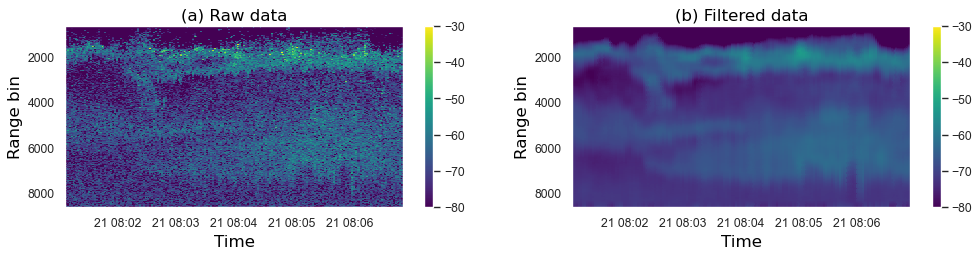

In [40]:
ds_s = smooth_backscatter(ds)

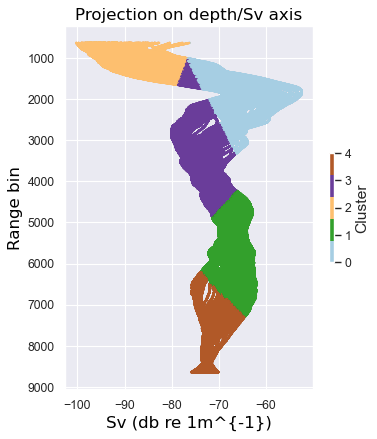

In [53]:
nclusters = 5
res = cluster_backscatter(ds_s, n_clusters=nclusters)

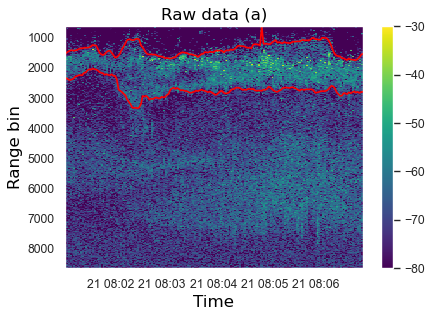

In [70]:
top_layer, bottom_layer = select_cluster(res,cluster_id=0)

In [71]:
write_ssl(fname, ds, top_layer, bottom_layer, nclusters)